# Goodness of Fit

Revisiting the regression objectives: After this page, 

<ol start="3">
  <li>You can measure the goodness of fit on a regression</li>
</ol> 


```{admonition} R$^2$ and Adjusted R$^2$

- $R^2 = 1-SSE/TSS$ = The fraction of variation in y that a model **can** explain, and always between 0 and 1.
- Adding extra variables to a model can not reduce R$^2$ *even if the variables are random*
- Adjusted R$^2$ adjusts R$^2$ by penalizing based on the number of variables in X. It can actually be negative. 
- `sm_ols(<model and data>).fit().summary()` automatically reports R$^2$ and Adjusted R$^2$
```

A key goal of just about any model is describing the data. In other words, how well does the model explain the data?

Intuitively, you look at these graphs and know that Model 1 describes the data better.

In [71]:
# load some data to practice regressions
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols

diamonds = sns.load_dataset('diamonds')

# this alteration is not strictly necessary to practice a regression
# but we use this in livecoding
np.random.seed(400)
diamonds2 = (diamonds
            .assign(lprice = np.log(diamonds['price']),
                    lcarat = np.log(diamonds['carat']),
                    ideal = diamonds['cut'] == 'Ideal',
                    lprice2 = lambda x: x.lprice + 2*np.random.randn(len(diamonds))
                   ) 
             
             .query('carat < 2.5') # censor/remove outliers
             
             # some regression packages want you to explicitly provide 
             # a variable for the constant
            .assign(const = 1)                           
            )  

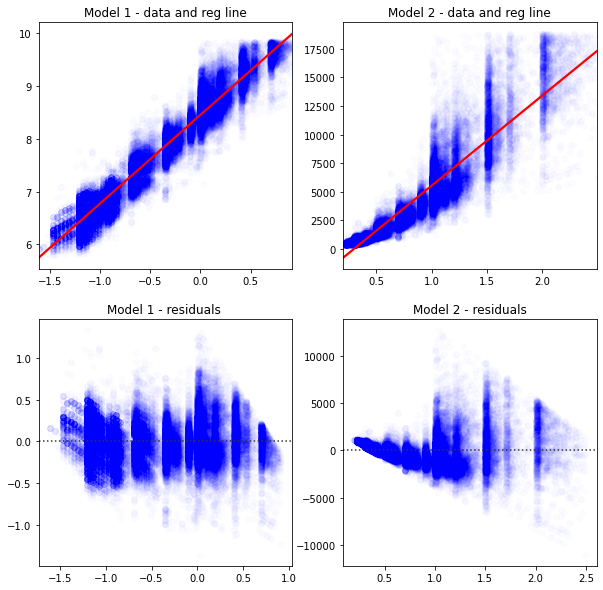

In [49]:
fig, axes = plt.subplots(2,2,figsize = (10,10))
sns.regplot(data=diamonds2,ax=axes[0,0],y='lprice',x='lcarat',
            scatter_kws = {'color': 'blue', 'alpha': 0.01},
            line_kws = {'color':'red'},
           ).set(xlabel='',ylabel='',title='Model 1 - data and reg line')

sns.regplot(data=diamonds2,ax=axes[0,1], y='price',x='carat',
            scatter_kws = {'color': 'blue', 'alpha': 0.01},
            line_kws = {'color':'red'},           
           ).set(xlabel='',ylabel='',title='Model 2 - data and reg line') 

sns.residplot(data=diamonds2,ax=axes[1,0],y='lprice',x='lcarat',
            scatter_kws = {'color': 'blue', 'alpha': 0.01},
            line_kws = {'color':'red'},
           ).set(xlabel='',ylabel='',title='Model 1 - residuals ')

sns.residplot(data=diamonds2,ax=axes[1,1], y='price',x='carat',
            scatter_kws = {'color': 'blue', 'alpha': 0.01},
            line_kws = {'color':'red'},
           ).set(xlabel='',ylabel='',title='Model 2 - residuals') 

plt.show()

The next graph shows two different y variables (shown in blue and orange). Again, it's fairly obvious that the blue points are better explained by the blue line than the orange is by the orange line. 

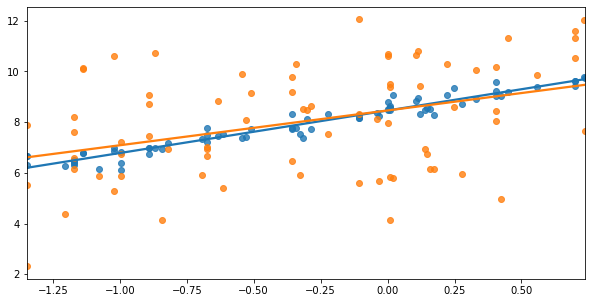

In [79]:
fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x='lcarat',y='lprice',ax=ax,
            data=diamonds2.sample(75,random_state=20),ci=None)
sns.regplot(x='lcarat',y='lprice2',ax=ax,
            data=diamonds2.sample(75,random_state=20),ci=None)
plt.xlabel("")
plt.ylabel("")
plt.show()


The way we can capture that statistically is by computing R$^2$. 
- Step 1: The total sum of squares: TSS $= \sum_i (y_i - \bar{y}_i)^2$ captures the total amount of variation in $y$ around its mean $\bar{y}$. We'd like to explain as much of this as possible.
- Step 2:  The sum of squared errors: SSE $= \sum_i (y_i - \hat{y}_i)^2$ captures the total amount of errors in the predictions. We'd like this to be as close to zero.
- Step 3: $SSE/TSS$ = The fraction of variation in y that a model **can't** explain

```{note}
$R^2 = 1-SSE/TSS$ = The fraction of variation in y that a model **can** explain
```

Statsmodels reports R$^2$ and Adjusted R$^2$  by default with `.summary()`.

Let's confirm that Model 1 > Model 2, and that Blue > Orange:

In [73]:
from statsmodels.iolib.summary2 import summary_col # nicer tables

# fit the two regressions, and save these as objects (containing the results)
res1 = sm_ols('lprice ~ lcarat',data=diamonds2).fit()
res2 = sm_ols('price ~ carat',data=diamonds2).fit()
res3 = sm_ols('lprice ~ lcarat',data=diamonds2).fit()
res4 = sm_ols('lprice2 ~ lcarat',data=diamonds2).fit()

# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

# This summary col function combines a bunch of regressions into one nice table
print(summary_col(results=[res1,res2,res3,res4],
                  float_format='%0.2f',
                  stars = True,
                  model_names=['Model 1','Model 2','Blue','Orange'],
                  info_dict=info_dict,
                  #regressor_order=[ # you can specify which variables you
                  # want at the top of the table here]
                  )
     )


                 Model 1   Model 2     Blue   Orange
----------------------------------------------------
Intercept        8.45*** -2335.81*** 8.45*** 8.45***
                 (0.00)  (12.98)     (0.00)  (0.01) 
R-squared        0.93    0.85        0.93    0.19   
R-squared Adj.   0.93    0.85        0.93    0.19   
carat                    7869.89***                 
                         (14.14)                    
lcarat           1.68***             1.68*** 1.69***
                 (0.00)              (0.00)  (0.01) 
R-squared        0.93    0.85        0.93    0.19   
Adj R-squared    0.93    0.85        0.93    0.19   
No. observations 53797   53797       53797   53797  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


![](https://media.giphy.com/media/YPTy760meD2xi/source.gif)